In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import pickle
from collections import deque

import pickle
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import os


In [4]:

def run_simulation(IS_INDUCED, L=20, N=200, fraction_core=0.25, T=1e-10, p=0.025, steps=400,
                   J_AA=-10, J_BB=-100):
    
    L = int(2*(N/np.pi)**(0.5))+2
    # Assign parameters
    N_B = int(N * fraction_core)   # number of B-type
    N_A = N - N_B
    
    # Initialize grid
    grid = -1 * np.ones((L, L), dtype=int)
    
    # Place cells in a circular region
    center = (L//2, L//2)
    positions = [(x, y) for x in range(L) for y in range(L)]
    positions.sort(key=lambda pos: (pos[0]-center[0])**2+(pos[1]-center[1])**2)
    selected_positions = positions[:N]
    np.random.shuffle(selected_positions)
    for i, (x, y) in enumerate(selected_positions):
        if i < N_A:
            grid[x, y] = 0 # A
        else:
            if IS_INDUCED:
                grid[x, y] = 1 # B (low)
            else:
                grid[x, y] = 2 # B (high)
    
    # Helper functions
    
    # could be either 4 or 8 neighbors. now chose 8
    def get_neighbors(x, y):
        nbrs = []
        # for dx, dy in [(1,0),(-1,0),(0,1),(0,-1)]:
        for dx, dy in [ (1,0),(-1,0),(0,1),(0,-1),
                        (-1,-1),(-1,1),(1,-1),(1,1)]:
            nx, ny = x+dx, y+dy
            if 0 <= nx < L and 0 <= ny < L:
                nbrs.append((nx, ny))
        return nbrs

    # here cores are only B_HIGH cells
    def count_cores(grid):
        visited = np.zeros_like(grid, dtype=bool)
        # directions = [(1,0),(-1,0),(0,1),(0,-1)]
        cores = 0
        L = grid.shape[0]

        for i in range(L):
            for j in range(L):
                if (grid[i,j] == 2) and not visited[i,j]:
                    # BFS/DFS to find connected component
                    cores += 1
                    queue = deque([(i,j)])
                    visited[i,j] = True
                    while queue:
                        x,y = queue.popleft()
                        for nx,ny in get_neighbors(x,y):
                        # for dx,dy in directions:
                        #     nx, ny = x+dx, y+dy
                            if 0<=nx<L and 0<=ny<L and not visited[nx,ny]:
                                if grid[nx,ny] == 2:
                                    visited[nx,ny] = True
                                    queue.append((nx,ny))
        return cores

    def local_energy(x, y):
        ctype = grid[x,y]
        if ctype == -1:
            return 0
        nbrs = get_neighbors(x,y)
        E = 0
        for nx, ny in nbrs:
            ntype = grid[nx, ny]
            if ntype == -1:
                continue
            # For simplicity, assume J_AB = J_AA as in the original code snippet
            if ctype==2 and ntype==2:
                E += J_BB
            else:
                E += J_AA
        return E
    
    def energy_difference_swap(x1, y1, x2, y2):
        E_before = local_energy(x1,y1) + local_energy(x2,y2)
        c1, c2 = grid[x1,y1], grid[x2,y2]
        grid[x1,y1], grid[x2,y2] = c2, c1
        E_after = local_energy(x1,y1) + local_energy(x2,y2)
        grid[x1,y1], grid[x2,y2] = c1, c2
        return E_after - E_before
    
    def attempt_state_transition(x, y):
        if np.random.rand() < p:
            if grid[x,y] == 1:
                nbrs = get_neighbors(x,y)
                A_count = sum(grid[nx,ny] == 0 for nx,ny in nbrs)
                if A_count >= 3:
                    grid[x,y] = 2 # B_low -> B_high
    
    def attempt_swap(x, y):
        nbrs = get_neighbors(x,y)
        ctype = grid[x,y]

        valid_nbrs = [nbr for nbr in nbrs if grid[nbr]!=ctype]  

        if len(valid_nbrs)==0: return        
        nx, ny = valid_nbrs[np.random.randint(len(valid_nbrs))]
        dE = energy_difference_swap(x,y,nx,ny)
        if dE <= 0:
            grid[x, y], grid[nx, ny] = grid[nx, ny], grid[x, y]
        else:
            if np.random.rand() < np.exp(-dE/T):
                grid[x, y], grid[nx, ny] = grid[nx, ny], grid[x, y]
    
    # Simulation loop
    grids_over_time = []
    cores_over_time = []
    for step_i in range(steps+1):
        # Record state
        grids_over_time.append(grid.copy())
        cores_over_time.append(count_cores(grid))
        
        if step_i == steps:
            break

        for _ in range(N):
            occ_positions = np.argwhere(grid != -1)
            x, y = occ_positions[np.random.randint(len(occ_positions))]
            attempt_state_transition(x, y)
            attempt_swap(x, y)
    
    return {"IS_INDUCED": IS_INDUCED,
            "grid_history": grids_over_time,
            "cores_history": cores_over_time,
            "parameters": {"L": L, "N": N, "fraction_core": fraction_core,
                           "T": T, "p": p, "steps": steps, "J_AA": J_AA, "J_BB": J_BB}}

###############################
# Run multiple simulations and save results
###############################
if not os.path.exists("simulation_results.pkl"):
    all_results_induced = []
    all_results_constitutive = []
    n_reps = 100

    for i in range(n_reps):
        res_induced = run_simulation(IS_INDUCED=True)
        all_results_induced.append(res_induced)
        res_const = run_simulation(IS_INDUCED=False)
        all_results_constitutive.append(res_const)

    # Save all results
    with open("simulation_results.pkl", "wb") as f:
        pickle.dump({"induced": all_results_induced, "constitutive": all_results_constitutive}, f)


In [5]:
with open("simulation_results.pkl", "rb") as f:
        data = pickle.load(f)

# Access the data
all_results_induced = data["induced"]
all_results_constitutive = data["constitutive"]

display timelapse for a single trial

31/12 update colors

compute E/E0 as a function of time

In [6]:
from scipy.ndimage import convolve

experiment_types = ['constitutive','induced']
filename = 'simulation_results.pkl'
with open(filename, "rb") as f:
    all_results = pickle.load(f)


# shape (trial,time,y,x)
grid_history = np.array([[g['grid_history'] for g in all_results[t]] for t in experiment_types])
# compute energies



# Define interaction energy lookup table
interaction_energy = np.zeros((3, 3), dtype=int)  # For values {0, 1, 2}
interaction_energy[2, 2] = -100
interaction_energy[0, :] = 0  # No interaction for 0
interaction_energy[:, 0] = 0
interaction_energy[1, 1] = -10
interaction_energy[1, 2] = -10
interaction_energy[2, 1] = -10

# Define convolution kernel for neighborhood
kernel = np.array([[1, 1, 1],
                   [1, 0, 1],
                   [1, 1, 1]])

trials,times = grid_history.shape[1:3]
# Compute Hamiltonian for each (trial, time)
hamiltonian = np.zeros((len(experiment_types),trials, times))
for exp_type in range(len(experiment_types)):
    for trial in range(trials):
        for time in range(times):
            grid = grid_history[exp_type,trial, time]
            
            # Compute neighbors for each grid cell
            neighbor_counts = {k: convolve((grid == k).astype(int), kernel, mode='constant', cval=0)
                            for k in [1, 2]}  # Only non-zero values matter
            
            # Compute interaction energy
            H = 0
            for k in [1, 2]:
                for j in [1, 2]:
                    H += interaction_energy[k, j] * np.sum(((grid == k) * neighbor_counts[j]))
            
            hamiltonian[exp_type,trial, time] = H // 2  # Each interaction is counted twice



Display results

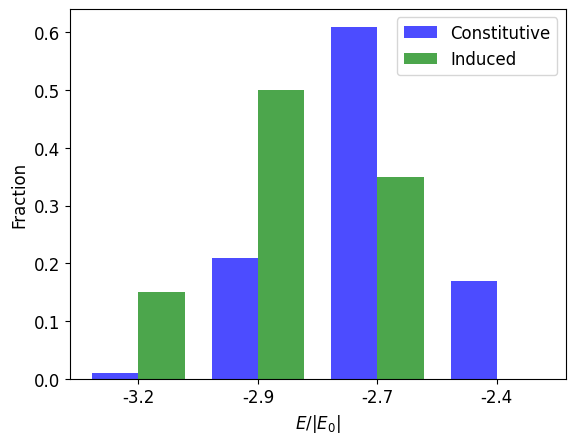

In [7]:
import numpy as np
import matplotlib.pyplot as plt
num_bins = 5

i_const, i_ind = 0, 1

# Bar plot at final step
E0 = np.abs(np.mean(hamiltonian[i_const, :, 0]))


E_const = hamiltonian[i_const, :, -1]/E0
E_ind = hamiltonian[i_ind, :, -1]/E0
bins = np.linspace(E_ind.min(), E_const.max(), num_bins)

bin_centers = (bins[:-1] + bins[1:]) / 2  # Midpoints of bins for plotting

# Histogram for Constitutive
hist_const, _ = np.histogram(hamiltonian[i_const, :, -1] / E0, bins=bins, density=False); hist_const = hist_const/sum(hist_const)

# Histogram for Induced
hist_ind, _ = np.histogram(hamiltonian[i_ind, :, -1] / E0, bins=bins, density=False); hist_ind = hist_ind/sum(hist_ind)

# Plotting histograms as bar plots
bar_width = 0.1
plt.bar(bin_centers - bar_width / 2, hist_const, 
        width=bar_width, alpha=0.7, label='Constitutive', color='blue')

plt.bar(bin_centers + bar_width / 2, hist_ind, 
        width=bar_width, alpha=0.7, label='Induced', color='green')

# Add labels and legend
plt.xlabel(r'$E / |E_0|$',fontsize=12)
plt.ylabel('Fraction',fontsize=12)
# plt.title('Hamiltonian Distribution at Final Step')
plt.legend(fontsize=12)
plt.xticks(bin_centers, labels=[f'{b:.1f}' for b in bin_centers],fontsize=12)
plt.yticks(fontsize=12)
plt.show()
